In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas_profiling

In [3]:
df= pd.read_csv('Train.txt')

In [4]:
df.columns= ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [5]:
df01= df.copy()

In [6]:
#seprate categorical and contionus variables
df01_continous= df01.select_dtypes(include=['float64', 'int64'])

df01_categorical= df01.select_dtypes(include=['object'])

###  Outlier Tretment

In [7]:
df01_continous = df01_continous.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [8]:
temp= df01_continous.apply(lambda x: x.clip(upper = x.quantile(0.985)))

In [9]:
temp1= pd.concat([temp, df01_categorical], axis=1, join='inner')

In [10]:
temp_test_2= temp1.copy()

In [11]:
temp3= temp1.copy()

In [12]:
# High Cardinality treatment
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(temp1['service'])
temp_test_2.service= le.transform(temp1['service']) 

In [13]:
# Dummy Variable Creation 
categorial_features= ['protocol_type', 'flag']
# An utility function to create dummy variable
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [14]:
for c_feature in categorial_features:
    temp_test_2= create_dummies(temp_test_2, c_feature)

In [15]:
for c_feature in categorial_features:
    temp3= create_dummies(temp3, c_feature)

In [16]:
### for Multi Class Classification
temp3.attack.loc[temp3.attack== 'normal']= 'Normal'
temp3.attack.loc[temp3.attack.isin(['back','land', 'neptune', 'teardrop', 'smurf', 'pod', 'apache2', 'udpstorm', 'processtable', 'worm'])] ='DoS'
temp3.attack.loc[temp3.attack.isin(['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint'])]= 'Probe'
temp3.attack.loc[temp3.attack.isin(['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop'
                  'snmguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named'])]= 'R2L'
temp3.attack.loc[temp3.attack.isin(['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps'])]= 'U2R'

C:\Users\Krn\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
# High Cardinality treatment for multi class classification
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(temp1['service'])
temp3.service= le.transform(temp1['service']) 

In [18]:
temp3.drop_duplicates(keep='first', inplace= True)

In [19]:
temp_test_2.attack= np.where(temp_test_2.attack== 'normal', 1, 0)

In [20]:
temp_test_2.drop_duplicates(keep='first', inplace= True)

###  Model Data Train Test

In [21]:
feature_columns= temp_test_2.columns.difference(["hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag" ])

In [22]:
from sklearn.model_selection import train_test_split


train_X_dt, test_X_dt, train_y_dt, test_y_dt = train_test_split(temp_test_2[feature_columns] ,
                                                  temp_test_2['attack'],
                                                  test_size = 0.3,
                                                  random_state = 123 )

###  D.T model 1 Normal vs Rest

In [23]:
import sklearn.tree as dt

In [24]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.model_selection import GridSearchCV

C:\Users\Krn\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
train_X_dt.shape

(87507, 19)

In [27]:
param_grid = {'max_depth': np.arange(2, 12),
             'max_features': np.arange(10,18)}

In [28]:
train_y_dt.shape

(87507,)

In [23]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 10,verbose=1,n_jobs=-1)
tree.fit( train_X_dt, train_y_dt )

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.0min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': array([10

In [24]:
tree.best_score_

0.9925491674951719

In [25]:
tree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [26]:
tree.best_params_

{'max_depth': 11, 'max_features': 15}

In [27]:
train_pred = tree.predict(train_X_dt)

In [28]:
print(metrics.classification_report(train_y_dt, train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     40319
           1       1.00      0.99      0.99     47188

    accuracy                           0.99     87507
   macro avg       0.99      0.99      0.99     87507
weighted avg       0.99      0.99      0.99     87507



In [29]:
test_pred = tree.predict(test_X_dt)

In [30]:
print(metrics.classification_report(test_y_dt, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     17442
           1       1.00      0.99      0.99     20062

    accuracy                           0.99     37504
   macro avg       0.99      0.99      0.99     37504
weighted avg       0.99      0.99      0.99     37504



In [29]:
clf_tree = DecisionTreeClassifier( max_depth = 11, max_features=15)
clf_tree.fit( train_X_dt, train_y_dt )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [30]:
train_X_dt.columns

Index(['dst_bytes', 'duration', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0',
       'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF',
       'flag_SH', 'land', 'protocol_type_tcp', 'protocol_type_udp', 'service',
       'src_bytes', 'urgent', 'wrong_fragment'],
      dtype='object')

In [31]:
clf_tree.feature_importances_

array([4.81090416e-02, 1.72167133e-02, 1.44350515e-02, 1.38635104e-03,
       0.00000000e+00, 2.52705343e-04, 3.55215304e-08, 9.60561427e-04,
       1.90982421e-04, 0.00000000e+00, 9.42095293e-05, 0.00000000e+00,
       0.00000000e+00, 7.19262916e-02, 4.74432590e-04, 7.04469998e-02,
       7.74506624e-01, 0.00000000e+00, 0.00000000e+00])

In [32]:
list(zip(train_X_dt.columns,clf_tree.feature_importances_ ))

[('dst_bytes', 0.04810904162571907),
 ('duration', 0.017216713297279647),
 ('flag_REJ', 0.014435051537234189),
 ('flag_RSTO', 0.0013863510378419723),
 ('flag_RSTOS0', 0.0),
 ('flag_RSTR', 0.00025270534287083013),
 ('flag_S0', 3.552153042979471e-08),
 ('flag_S1', 0.0009605614274767979),
 ('flag_S2', 0.0001909824210565706),
 ('flag_S3', 0.0),
 ('flag_SF', 9.420952925285276e-05),
 ('flag_SH', 0.0),
 ('land', 0.0),
 ('protocol_type_tcp', 0.07192629155461382),
 ('protocol_type_udp', 0.0004744325900803715),
 ('service', 0.07044699981089422),
 ('src_bytes', 0.7745066243041492),
 ('urgent', 0.0),
 ('wrong_fragment', 0.0)]

In [33]:
tree_test_pred_dt = pd.DataFrame( { 'actual':  test_y_dt,
                            'predicted': clf_tree.predict( test_X_dt ) } )

In [39]:
tree_test_pred_dt.to_excel('Output Decision Tree Normal Classification.xlsx')

In [34]:
tree_test_pred_dt.sample( n = 10 )

,actual,predicted
48236,0,0
108053,1,1
2421,0,0
104044,1,1
94322,0,0
46116,0,0
50597,1,1
100569,1,1
113621,1,1
122994,0,0


In [35]:
metrics.accuracy_score( tree_test_pred_dt.actual, tree_test_pred_dt.predicted )

0.9936540102389079

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 12.5, 'Predicted label')

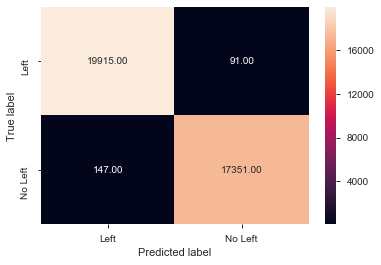

In [37]:
tree_cm = metrics.confusion_matrix( tree_test_pred_dt.predicted,
                                 tree_test_pred_dt.actual,
                                 [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [38]:
metrics.roc_auc_score( tree_test_pred_dt.actual, tree_test_pred_dt.predicted )

0.9937277114948933

###  Dt multi-class classification

In [26]:
from sklearn.preprocessing import label_binarize

In [27]:
onevsrest= temp3.copy()

In [28]:
onevsrest_y= label_binarize(onevsrest.attack, classes=['Normal', 'DoS', 'R2L', 'Probe', 'U2R']) 
n_classes= 5

In [29]:
# Data for multiclass classification
from sklearn.model_selection import train_test_split


train_X_dt_mc, test_X_dt_mc, train_y_dt_mc, test_y_dt_mc = train_test_split(onevsrest[feature_columns] ,
                                                  onevsrest_y,
                                                  test_size = 0.3,
                                                  random_state = 12345 )

In [35]:
param_grid_mc = {'max_depth': np.arange(2, 12),
             'max_features': np.arange(10,18)}

In [36]:
tree_mc = GridSearchCV(DecisionTreeClassifier(), param_grid_mc, cv = 10,verbose=1,n_jobs=-1)
tree_mc.fit( train_X_dt_mc, train_y_dt_mc )

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': array([10

In [37]:
tree_mc.best_score_

0.9757390837304444

In [38]:
tree_mc.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=16, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
tree_mc.best_params_

{'max_depth': 11, 'max_features': 16}

In [41]:
train_pred_mc = tree_mc.predict(train_X_dt_mc)

In [42]:
print(metrics.classification_report(train_y_dt_mc, train_pred_mc))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     47045
           1       0.95      0.99      0.97     32155
           2       0.99      0.99      0.99       696
           3       0.99      0.80      0.89      7576
           4       1.00      0.63      0.77        35

   micro avg       0.98      0.98      0.98     87507
   macro avg       0.98      0.88      0.92     87507
weighted avg       0.98      0.98      0.98     87507
 samples avg       0.98      0.98      0.98     87507



C:\Users\Krn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [43]:
test_pred_mc = tree_mc.predict(test_X_dt_mc)

In [44]:
print(metrics.classification_report(test_y_dt_mc, test_pred_mc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20205
           1       0.95      0.99      0.97     13749
           2       0.97      0.96      0.96       298
           3       0.99      0.79      0.88      3235
           4       0.40      0.24      0.30        17

   micro avg       0.98      0.97      0.97     37504
   macro avg       0.86      0.79      0.82     37504
weighted avg       0.98      0.97      0.97     37504
 samples avg       0.97      0.97      0.97     37504



C:\Users\Krn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [45]:
dt_multi_clf = DecisionTreeClassifier(max_depth=11 ,max_features=16, )
dt_multi_clf.fit( train_X_dt_mc, train_y_dt_mc )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=16, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [46]:
predicte= dt_multi_clf.predict( test_X_dt_mc )

In [49]:
df2=pd.DataFrame(np.array(predicte),
                   columns=['class 0 Predicted', 'Class 1 Predicted', 'Class 2 Predicted', 'Class 3 Predicted', 'Class4 Predicted'])

In [50]:
df3= pd.DataFrame(test_y_dt_mc, columns=['class 0 Actual', 'Class 1 Actual', 'Class 2 Actual', 'Class 3 Actual', 'Class4 Actual'])

In [51]:
out= pd.concat([df2, df3], axis=1)

In [52]:
out.head()

,class 0 Predicted,Class 1 Predicted,Class 2 Predicted,Class 3 Predicted,Class4 Predicted,class 0 Actual,Class 1 Actual,Class 2 Actual,Class 3 Actual,Class4 Actual
0,0,1,0,0,0,0,1,0,0,0
1,1,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0


In [53]:
out.to_excel('Dt multiClass Output.xlsx')

###  data for random forest

In [30]:
from sklearn.model_selection import train_test_split


train_X_rf, test_X_rf, train_y_rf, test_y_rf = train_test_split(temp_test_2[feature_columns] ,
                                                  temp_test_2['attack'],
                                                  test_size = 0.3,
                                                  random_state = 1234 )

0    1
1    0
2    1
3    1
4    0
Name: attack, dtype: int32

###  Random  Forest normal vs rest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
pargrid_rf = {'n_estimators': [50, 60, 70, 80, 90, 100],
                  'max_features': [5,6,7,8,9,10,11,12]}

#from sklearn.grid_search import GridSearchCV
gscv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_rf, 
                        cv=10,
                        verbose=True, n_jobs=-1)

gscv_results = gscv_rf.fit(train_X_rf, train_y_rf)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 28.0min finished


In [45]:
gscv_results.best_params_

{'max_features': 9, 'n_estimators': 100}

In [46]:
gscv_rf.best_score_

0.9933948141291554

In [32]:
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=100, max_features=9, n_jobs=-1)
radm_clf.fit( train_X_rf, train_y_rf )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [33]:
radm_test_pred = pd.DataFrame( { 'actual':  test_y_rf,
                            'predicted': radm_clf.predict( test_X_rf ) } )

In [34]:
radm_test_pred.to_excel('Random forest Normal Classification.xlsx')

In [35]:
from sklearn import metrics

In [36]:
print(metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted ))
print(metrics.roc_auc_score( radm_test_pred.actual, radm_test_pred.predicted ))

0.9934673634812287
0.9935761034299204


Text(0.5, 12.5, 'Predicted label')

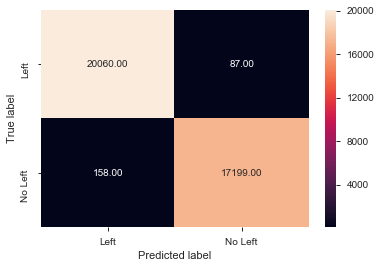

In [37]:
tree_cm_rf = metrics.confusion_matrix( radm_test_pred.predicted,
                                 radm_test_pred.actual,
                                 [1,0] )
sns.heatmap(tree_cm_rf, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

In [51]:
### Feature importance from the Random Forest Model

In [61]:
print(radm_clf.feature_importances_)
print(np.argsort(radm_clf.feature_importances_))

[2.28688642e-01 7.60568780e-03 1.09683116e-02 1.08500161e-03
 6.14746386e-05 7.13342553e-04 3.82559760e-02 1.57734908e-03
 1.77014843e-04 5.87094220e-05 8.11620287e-02 4.53717547e-05
 0.00000000e+00 2.70244374e-02 3.90789460e-03 1.01283499e-01
 4.97385259e-01 0.00000000e+00 0.00000000e+00]
[18 12 17 11  9  4  8  5  3  7 14  1  2 13  6 10 15  0 16]


In [62]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]

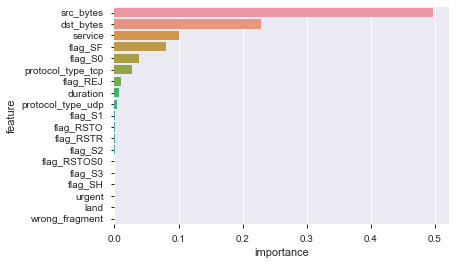

In [63]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X_rf.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X_rf.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

###  Random Forest multiclass classifiaction....

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
onevsrest_rf= temp3.copy()

In [66]:
onevsrest_y_rf_mc= label_binarize(onevsrest_rf.attack, classes=['Normal', 'DoS', 'R2L', 'Probe', 'U2R']) 
n_classes= 5

In [68]:
# Data for multiclass classification
from sklearn.model_selection import train_test_split


train_X_rf_mc, test_X_rf_mc, train_y_rf_mc, test_y_rf_mc = train_test_split(onevsrest_rf[feature_columns] ,
                                                  onevsrest_y_rf_mc,
                                                  test_size = 0.3,
                                                  random_state = 12345 )

In [78]:
pargrid_rf = {'n_estimators': [50, 60, 70, 80, 90, 100],
                  'max_features': [5,6,7,8,9,10,11,12]}

#from sklearn.grid_search import GridSearchCV
gscv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_rf, 
                        cv=10,
                        verbose=True, n_jobs=-1)

gscv_results = gscv_rf.fit(train_X_rf_mc, train_y_rf_mc)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 49.3min finished


In [79]:
gscv_results.best_params_

{'max_features': 7, 'n_estimators': 70}

In [80]:
gscv_rf.best_score_

0.9768247050949281

In [70]:
radm_clf_mc = RandomForestClassifier(oob_score=True,n_estimators=70, max_features=7, n_jobs=-1)
radm_clf_mc.fit( train_X_rf_mc, train_y_rf_mc )


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [85]:
predic = radm_clf_mc.predict(test_X_rf_mc)

In [83]:
onevsrest_y_rf_mc

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [82]:
test_y_rf_mc

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [86]:
df2_rf_mc=pd.DataFrame(np.array(predic),
                   columns=['class 0 Predicted', 'Class 1 Predicted', 'Class 2 Predicted', 'Class 3 Predicted', 'Class4 Predicted'])

In [88]:
df3_rf_mc= pd.DataFrame(onevsrest_y_rf_mc, columns=['class 0 Actual', 'Class 1 Actual', 'Class 2 Actual', 'Class 3 Actual', 'Class4 Actual'])

In [89]:
out_mc= pd.concat([df2_rf_mc, df3_rf_mc], axis=1)

In [91]:
out_mc.to_excel('Random Forest Multiclass Output.xlsx')

In [92]:
#print(metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted ))#print(metrics.roc_auc_score( radm_test_pred.actual, radm_test_pred.predicted ))

In [94]:
print(radm_clf_mc.feature_importances_)
print(np.argsort(radm_clf_mc.feature_importances_))

[1.23253437e-01 1.13103114e-02 1.39540292e-02 6.35667783e-03
 4.28674527e-04 1.56357595e-02 1.16079358e-01 6.81318420e-04
 1.36229665e-04 4.85252677e-05 1.37681060e-01 2.17637492e-03
 0.00000000e+00 3.26598198e-02 6.23953435e-03 1.18677346e-01
 4.14681544e-01 0.00000000e+00 0.00000000e+00]
[18 12 17  9  8  4  7 11 14  3  1  2  5 13  6 15  0 10 16]


In [95]:
indices = np.argsort(radm_clf_mc.feature_importances_)[::-1]

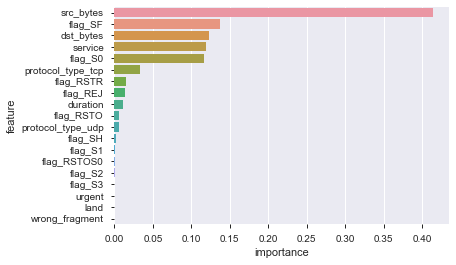

In [96]:
indices = np.argsort(radm_clf_mc.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X_rf_mc.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X_rf_mc.columns[indices[f]],
                         radm_clf_mc.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

In [139]:
# from sklearn.metrics import roc_curve, auc


In [ ]:
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(test_y_rf_mc[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

In [97]:
from sklearn.preprocessing import StandardScaler

In [98]:
sc= StandardScaler()
X_train = sc.fit_transform(train_X_rf_mc)
X_test = sc.transform(test_X_rf_mc)

In [99]:
classifier_2= RandomForestClassifier(n_estimators=70,max_features=7, criterion='entropy', random_state=1233)
classifier_2.fit(X_train, train_y_rf_mc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=1233,
                       verbose=0, warm_start=False)

In [100]:
# Fitting Random Forest Classification to the Training set
classifier_2 = RandomForestClassifier(n_estimators = 70, criterion = 'entropy', random_state = 42)
classifier_2.fit(train_X_rf_mc, train_y_rf_mc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [104]:
print(metrics.accuracy_score( test_y_rf_mc, y_pred_rf_mc))

0.9765091723549488


In [106]:
df2_rf_mc_sc=pd.DataFrame(np.array(predic),
                   columns=['class 0 Predicted', 'Class 1 Predicted', 'Class 2 Predicted', 'Class 3 Predicted', 'Class4 Predicted'])

In [105]:
df3_rf_mc_sc= pd.DataFrame(onevsrest_y_rf_mc, columns=['class 0 Actual', 'Class 1 Actual', 'Class 2 Actual', 'Class 3 Actual', 'Class4 Actual'])

In [107]:
sc_out_mc= pd.concat([df2_rf_mc_sc, df3_rf_mc_sc], axis=1)

In [108]:
sc_out_mc.to_excel('standard scaler multiclass random forest.xlsx')